# Sensitivity analysis for CASSIE post-processing

**Datasets this notebook expects to find** under the below given datapaths:
- 4 folders, each containing a file `coastlines.shp` (output of Cassie webinterface application):
    - `12_cassie_landsat_1984-04-30_1992-09-04_ext1000_spac5000_base2_multi-thresh/`
    - `13_cassie_landsat_1992-09-20_2003-08-02_ext1000_spac5000_base2_multi-thresh/`
    - `18_cassie_landsat_2003-09-19_2015-03-12_ext1300_spac5000_base1_multi-thresh/`
    - `17_cassie_landsat_2015-04-13_2023-02-22_ext1300_spac5000_base1_multi-thresh/`
- File `jarkus_transects_EPSG32631_reduced.geojson`  (output of jarkus_shoreline.ipynb, but manually removed overlapping transects in the curvatures with QGIS)
- File `TG_rijkswaterstaat_1992_01_01-2021_12_31.csv` (combined and cleaned individual .csv files from rijkswaterstaat using function `prepare_TG_rijkswaterstaat_data` in the coastal_data module)
- File `transect_red_with_derivatives.nc` (output of jarkus_shoreline.ipynb)
- File `tidal_correction_10minutes.csv` (output of `tidal_correction_EOT_FES.ipynb`)

Files that are **created** in this notebook (in case they don't exist):
- 2 files `cassie_sens_along_dist.pkl` and `cassie_sens_along_dist_qc.pkl`(intersection computation for several along_dist values)
- 2 files `cassie_sens_noqc.pkl` and `cassie_sens_qc.pkl` (using the intersection function with or without quality control)
- 2 files `cassie_sens_beach_slope_median_grad_buffer.pkl`, `cassie_sens_beach_slope_mean_grad_buffer` (beach slopes compute with variable median or variable mean and different values for the buffer zone)

**Required python modules**
- Adjusted [CoastSat](https://github.com/3enedix/CoastSat)
- [coastal_data](https://github.com/3enedix/coastal-sea-level/tree/main/coastal_data)

In [1]:
# Fill in your datapaths
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'
coastsat_git = '/home/bene/PhD-git/70_CoastSat'

## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import shapefile
import pandas as pd
import statistics
import numpy as np
import xarray as xr
import os
import pickle

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm

# toolboxes
import sys
sys.path.append(coastsat_git)
from coastsat import SDS_tools, SDS_transects

from coastal_data import CD_statistics, CD_helper_functions

# projection
from pyproj import CRS, Transformer

import pdb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# matplotlib fontsizes
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# png image resolution
dpi = 300

## Load data

In [5]:
# Foldernames to the CASSIE shape files
folders = ['12_cassie_landsat_1984-04-30_1992-09-04_ext1000_spac5000_base2_multi-thresh/',\
          '13_cassie_landsat_1992-09-20_2003-08-02_ext1000_spac5000_base2_multi-thresh/',\
          '18_cassie_landsat_2003-09-19_2015-03-12_ext1300_spac5000_base1_multi-thresh/',\
          '17_cassie_landsat_2015-04-13_2023-02-22_ext1300_spac5000_base1_multi-thresh/']
fn = 'coastlines'

# Transformation from EPSG 4326 to EPSG 32631
crs_4326 = CRS.from_epsg(4326)
crs_32631 = CRS.from_epsg(32631)
transformer = Transformer.from_crs(crs_4326, crs_32631)

datelist = []
sllist = []

for folder in folders:
    sf = shapefile.Reader(main_datapath_input + folder + fn)    
    shorelines = sf.shapeRecords().__geo_interface__ # shapefile to geojson
    for sl in shorelines['features']:
        date = pd.to_datetime(sl['properties']['date'], utc=True)
        date = date.to_pydatetime()
        datelist.append(date)

        sl_4326 = sl['geometry']['coordinates']
        sl_23631 = [transformer.transform(_[1], _[0]) for _ in sl_4326]
        sllist_temp = [list(_) for _ in sl_23631]

        sllist.append(np.array(sllist_temp))
        
# put the dates and shoreline coordinates in a dictionary (CoastSat-output-like)
sl_cassie = {'dates' : datelist, 'shorelines' : sllist}

## Load transects

In [6]:
# JARKUS-transects
fn = 'jarkus_transects_EPSG32631_reduced.geojson'
geojson_file = main_datapath_output + fn
transects = SDS_tools.transects_from_geojson(geojson_file)

152 transects have been loaded coordinates are in epsg:32631


## Initialise settings for timeseries

In [7]:
settings_ts = { # parameters for analysis of cross-shore time series
    'along_dist': 1200,    # along-shore distance to use for computing the intersection
    'sm_window_size' : 5, # window size for smoothing
    # tidal correction
    'beach_slope' : 'variable_median', #  number (= uniform beach slope), 'variable_median' or 'variable_mean'
    'grad_buffer' : 45, # [m], 1/2 length of the zone where the gradients in each point are considered for mean or median
    'water_levels_source' : 'tg', #'tg' or 'eot'
    'tide_corr_thresh' : 100, # [m], threshold for maximum tidal correction     
                    }

## Intersection computation

### Along-shore distance

In [8]:
# Compute timeseries for all transects and for several along_dist values
def along_dist_experiments(settings_transects, qc):
    transect_nr = list(transects.keys())
    cd_along = pd.DataFrame(columns=transect_nr, index=along_dist_values)
    cd_along.index.name = 'along_dist'
    for i, along_dist in enumerate(along_dist_values):
        settings_transects['along_dist'] = along_dist
        if qc == 'noqc':
            cd_cassie = SDS_transects.compute_intersection(sl_cassie, transects, settings_transects)
        elif qc == 'qc':   
            cd_cassie = SDS_transects.compute_intersection_QC(sl_cassie, transects, settings_transects)
        
        cd_cassie_sm = {}
        for key in cd_cassie.keys():
            # Interpolate over the nans
            cd_cassie[key] = np.array(pd.Series(cd_cassie[key]).interpolate())
            # Smoothing
            cd_cassie_sm[key] = CD_statistics.moving_average(cd_cassie[key], settings_ts['sm_window_size'])
            cd_along.loc[along_dist, key] = cd_cassie_sm[key]
    return cd_along

along_dist_values = range(50,2500,200)

# not quality controlled
if not os.path.isfile(main_datapath_output + 'cassie_sens_along_dist.pkl'):
    # initialise settings dict, but along_dist will change
    settings_transects = {
        'along_dist': settings_ts['along_dist'],     # along-shore distance to use for computing the intersection
        'max_dist_origin': 10000,                    # maximum distance to the origin of a transect in [m]
                     }
    cd_along = along_dist_experiments(settings_transects, 'noqc')
    cd_along.to_pickle(main_datapath_output + 'cassie_sens_along_dist.pkl')
else:
    cd_along = pd.read_pickle(main_datapath_output + 'cassie_sens_along_dist.pkl')

# Remove the first 6 transects (outliers)
cd_along.drop(cd_along.columns[0:5], axis=1, inplace=True)

# quality controlled
if not os.path.isfile(main_datapath_output + 'cassie_sens_along_dist_qc.pkl'):
    settings_transects_qc = { # parameters for computing intersections
                  'along_dist': settings_ts['along_dist'],    # along-shore distance to use for computing the intersection
                  'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                  'max_std':             15,        # max std for points around transect
                  'max_range':           30,        # max range for points around transect
                  'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                  'multiple_inter':      'max',     # mode for removing outliers ('auto', 'nan', 'max')
                  'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                  'max_dist_origin':      10000,    # maximum distance to the origin of a transect in [m]
                }
    cd_along_qc = along_dist_experiments(settings_transects_qc, 'qc')
    cd_along_qc.to_pickle(main_datapath_output + 'cassie_sens_along_dist_qc.pkl')
else:
    cd_along_qc = pd.read_pickle(main_datapath_output + 'cassie_sens_along_dist_qc.pkl')

#### Statistics for the non-quality controlled timeseries

In [9]:
def compute_transect_medians(data_df):
    '''
    Compute the median per transect of all solutions in data_df
    data_df: DataFrame, rows: different solutions, e.g. along_dist values, columns: transects, per cell one timeseries
    '''
    transect_medians = {}
    for transect in data_df.columns:
        combined_single_transect = np.empty(len(data_df.iloc[0,0])) # length of one timeseries
        for solution in data_df.index:
            combined_single_transect = np.vstack([combined_single_transect,
                                                           data_df.loc[solution,transect]])
        combined_single_transect = np.delete(combined_single_transect, 0, 0)

        transect_medians[transect] = np.median(combined_single_transect, axis=0)
    return transect_medians

In [10]:
def compute_statistics(data_df, transect_medians, sl):
    '''
    Compute standard deviations, trends and difference to median (median, mean, min and max of all solutions)
    (for the differences, take the median per transect)
    '''
    # timevector for trend
    x = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl['dates']))
    
    std_av = pd.DataFrame(columns=['median', 'mean', 'min', 'max'], index=data_df.index)
    trend_av = std_av.copy()
    diff_to_median = std_av.copy()
    
    for solution in data_df.index:
        std_list = []
        trend_list = []
        diff = []
        for transect in data_df.columns:
            ts = data_df.loc[solution, transect]
            if np.all(np.isnan(ts)):
                continue
            ts_nonan = ts[~np.isnan(ts)]            

            std_list.append(statistics.stdev(ts_nonan)) # when first value is nan, then std is nan
            trend_list.append(CD_statistics.compute_trend(x, ts))
            diff.append(np.nanmedian(transect_medians[transect] - ts))

        std_av.loc[solution, 'median'] = round(np.median(std_list),2)
        std_av.loc[solution, 'mean'] = round(np.mean(std_list),2)
        std_av.loc[solution, 'min'] = round(np.min(std_list),2)
        std_av.loc[solution, 'max'] = round(np.max(std_list),2)

        trend_av.loc[solution, 'median'] = round(np.median(trend_list),2)
        trend_av.loc[solution, 'mean'] = round(np.mean(trend_list),2)
        trend_av.loc[solution, 'min'] = round(np.min(trend_list),2)
        trend_av.loc[solution, 'max'] = round(np.max(trend_list),2) 

        diff_to_median.loc[solution, 'median'] = round(np.nanmedian(diff),2)
        diff_to_median.loc[solution, 'mean'] = round(np.nanmean(diff),2)
        diff_to_median.loc[solution, 'min'] = round(np.nanmin(diff),2)
        diff_to_median.loc[solution, 'max'] = round(np.nanmax(diff),2)

    print('std [m]')
    display(std_av)
    print('trend [m/year]')
    display(trend_av)
    print('Difference to median of all solutions [m]:')
    display(diff_to_median)
    
    return std_av, trend_av, diff_to_median

In [11]:
cd_along_transect_medians = compute_transect_medians(cd_along)
along_std, along_trend, along_diff = compute_statistics(cd_along, cd_along_transect_medians, sl_cassie)

std [m]


,median,mean,min,max
along_dist,,,,
50,87.09,167.73,28.26,5794.75
250,88.3,160.78,28.14,4814.33
450,87.72,154.13,30.31,3920.62
650,85.03,151.39,31.4,3533.83
850,84.17,144.83,31.03,2457.09
1050,84.44,143.74,31.92,2178.67
1250,83.22,142.91,32.67,2000.59
1450,81.65,142.47,31.22,1881.79
1650,80.39,140.2,31.08,1543.21


trend [m/year]


,median,mean,min,max
along_dist,,,,
50,-1.86,-2.88,-42.91,410.55
250,-1.89,-3.49,-42.48,319.62
450,-2.01,-4.06,-43.95,231.52
650,-1.94,-4.36,-47.06,186.45
850,-1.69,-5.57,-54.28,16.14
1050,-2.04,-6.08,-56.67,7.06
1250,-1.95,-6.14,-64.04,7.02
1450,-1.81,-6.13,-65.34,7.11
1650,-1.87,-6.08,-65.23,7.07


Difference to median of all solutions [m]:


,median,mean,min,max
along_dist,,,,
50,-1.09,13.1,-254.5,3075.31
250,-0.41,18.98,-230.89,3895.17
450,0.0,8.53,-213.32,2463.92
650,0.0,-11.05,-433.47,34.31
850,-0.1,-11.25,-760.52,16.6
1050,-0.38,-8.94,-731.72,13.62
1250,0.0,-3.46,-439.3,6.13
1450,0.0,4.59,-22.46,129.98
1650,0.0,8.54,-23.2,216.39


#### Statistics for the quality controlled timeseries

In [12]:
cd_along_qc_transect_medians = compute_transect_medians(cd_along_qc)
along_qc_std, along_qc_trend, along_qc_diff = compute_statistics(cd_along_qc, cd_along_qc_transect_medians, sl_cassie)

std [m]


,median,mean,min,max
along_dist,,,,
50,120.5,154.67,41.47,553.06
250,98.73,136.89,39.51,550.86
450,102.57,139.02,41.35,543.63
650,105.57,141.19,43.0,544.23
850,108.42,143.35,44.39,546.33
1050,111.78,145.42,45.52,545.91
1250,113.77,147.79,47.31,544.81
1450,116.0,150.42,54.71,548.19
1650,117.5,153.04,56.64,547.98


trend [m/year]


,median,mean,min,max
along_dist,,,,
50,-1.74,-5.25,-42.48,16.74
250,-1.64,-5.22,-42.34,14.48
450,-1.51,-5.18,-42.07,11.33
650,-1.62,-5.15,-42.04,10.62
850,-1.64,-5.18,-42.36,10.38
1050,-1.58,-5.22,-42.35,10.38
1250,-1.74,-5.3,-42.3,10.38
1450,-2.0,-5.39,-42.54,10.21
1650,-2.47,-5.52,-42.52,10.21


Difference to median of all solutions [m]:


,median,mean,min,max
along_dist,,,,
50,84.34,94.8,11.87,296.84
250,78.63,78.6,0.0,257.8
450,54.56,55.43,0.0,187.51
650,37.86,37.28,0.0,133.44
850,20.67,22.72,0.0,84.81
1050,8.78,10.4,0.0,36.48
1250,0.0,0.0,0.0,0.0
1450,-5.98,-8.75,-32.75,0.0
1650,-17.38,-19.29,-67.06,0.0


##### Combined plot

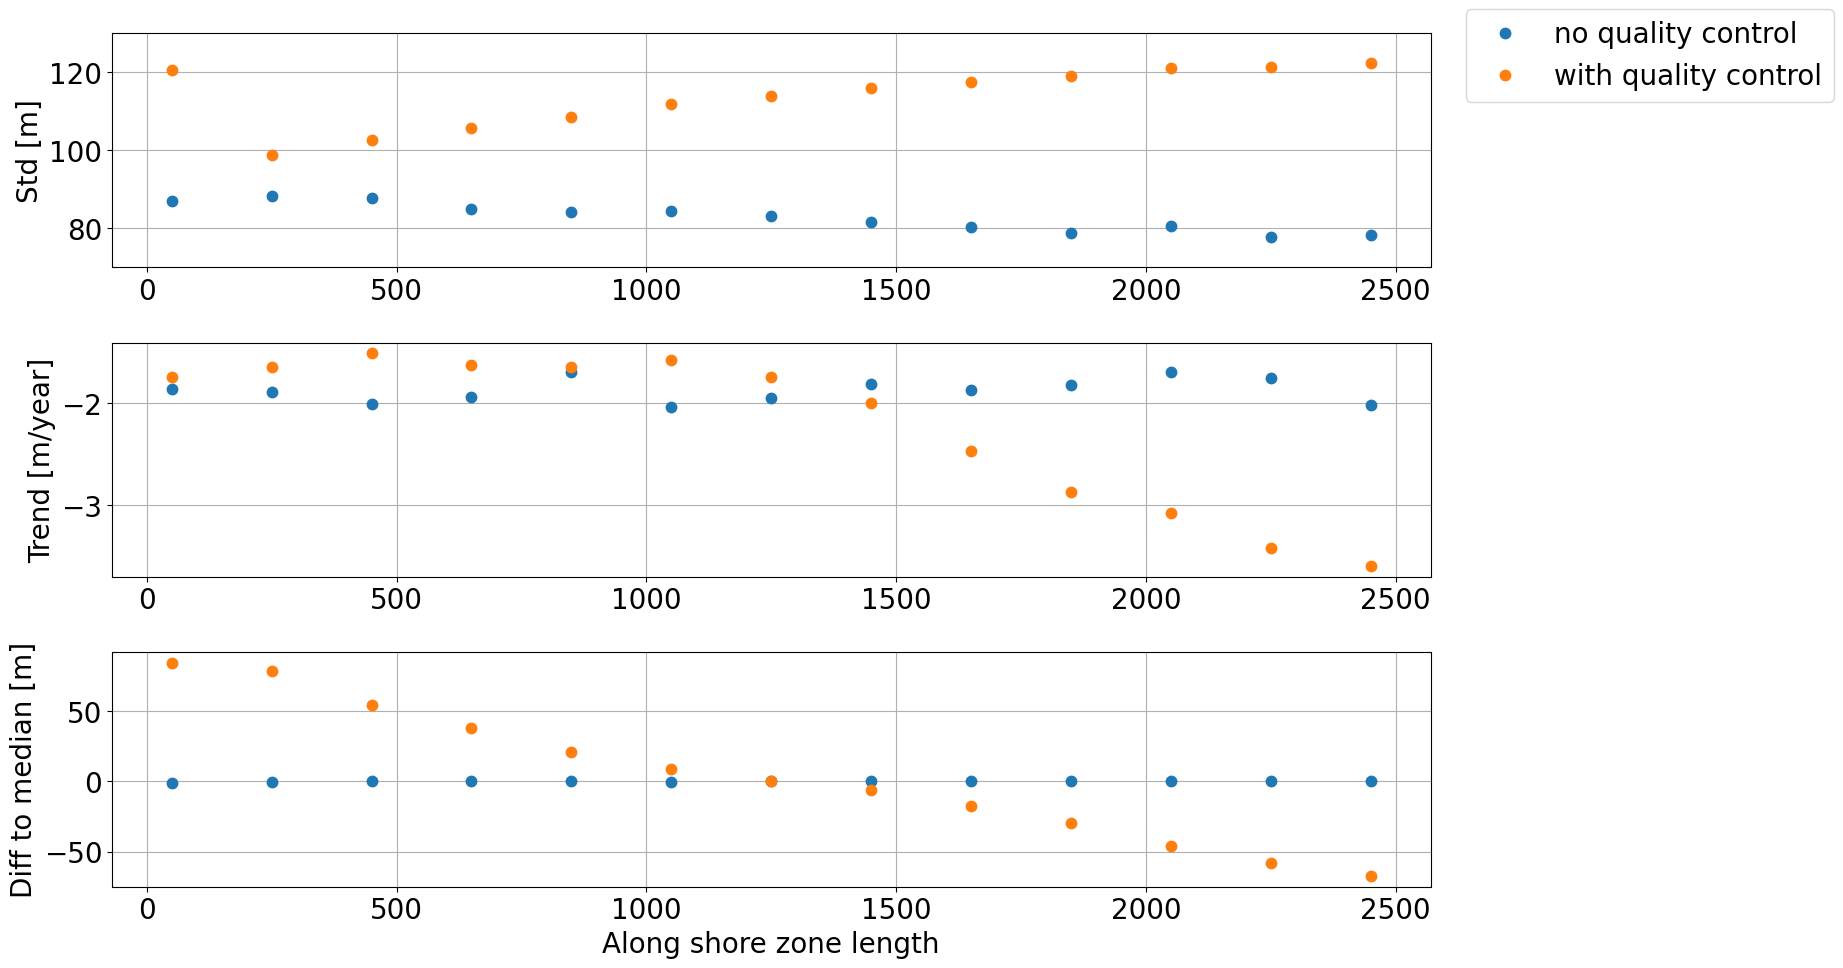

In [13]:
def plot_statistics(ax, data, ylabel, label=""):
    ax.plot(data, '.', markersize=15, label=label)
    ax.set_ylabel(ylabel)

fig, axs = plt.subplots(3,1,figsize=(15,10))
plot_statistics(axs[0], along_std['median'], 'Std [m]', 'no quality control')
plot_statistics(axs[0], along_qc_std['median'], 'Std [m]', 'with quality control')
axs[0].grid()
axs[0].set_ylim([70, 130])

plot_statistics(axs[1], along_trend['median'], 'Trend [m/year]')
plot_statistics(axs[1], along_qc_trend['median'], 'Trend [m/year]')
axs[1].grid()

plot_statistics(axs[2], along_diff['median'], 'Diff to median [m]')
plot_statistics(axs[2], along_qc_diff['median'], 'Diff to median [m]')
axs[2].grid()
axs[2].set_xlabel('Along shore zone length')

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.25,1))
plt.savefig('../99_plot_dump/cassie_sens_along_dist.png', dpi=dpi, bbox_inches='tight')

### Type of intersection computation (with or without "quality control")

In [14]:
diff = cd_along - cd_along_qc

####  (Median) Differences per transect

In [15]:
transect_med = []
for transect in diff.columns:
    ts_med = []
    for along_dist in diff.index:
        ts_med.append(np.nanmedian(diff.loc[along_dist, transect]))
    transect_med.append(np.nanmedian(ts_med))

/tmp/ipykernel_28215/3329583374.py:5: RuntimeWarning: All-NaN slice encountered
  ts_med.append(np.nanmedian(diff.loc[along_dist, transect]))
/tmp/ipykernel_28215/3329583374.py:6: RuntimeWarning: All-NaN slice encountered
  transect_med.append(np.nanmedian(ts_med))


In [16]:
np.nanmedian(transect_med)

-115.00806389792115

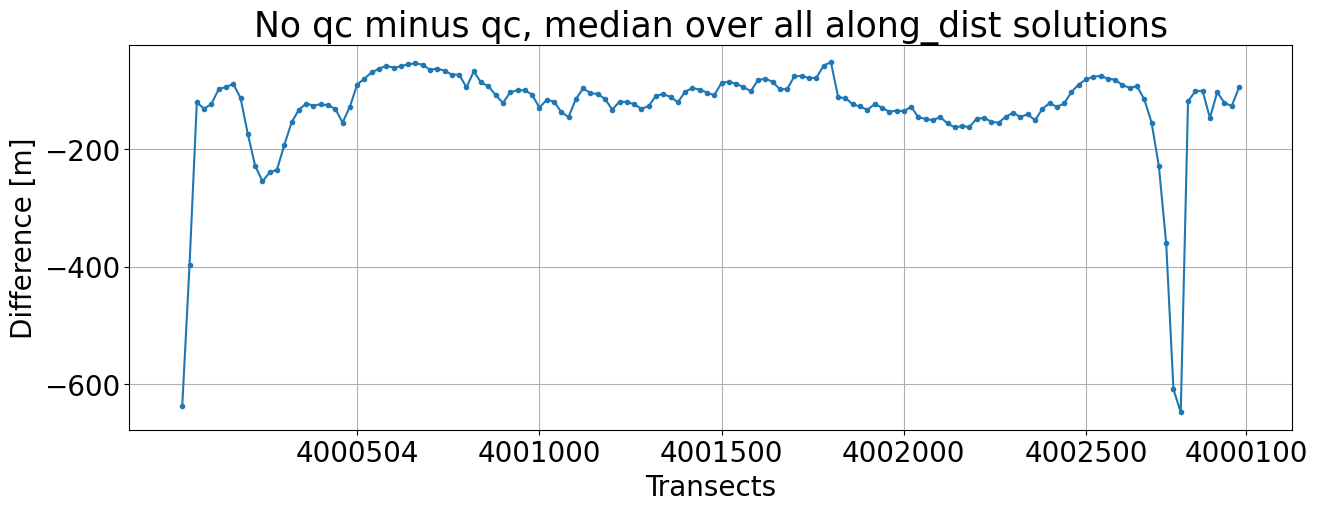

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(diff.columns, transect_med)
ax.plot(diff.columns[6:], transect_med[6:], '.-')
xticks = cd_along.columns[0::25]
ax.set_xticks(xticks)
ax.set_xlabel('Transects')
ax.set_ylabel('Difference [m]')
ax.set_title("No qc minus qc, median over all along_dist solutions")
ax.grid()

#### (Median) Differences per along_dist value

In [18]:
solution_med = []
for along_dist in diff.index:
    ts_med = []
    for transect in diff.columns:
        ts_med.append(np.nanmedian(diff.loc[along_dist, transect]))
    solution_med.append(np.nanmedian(ts_med))

/tmp/ipykernel_28215/1664098702.py:5: RuntimeWarning: All-NaN slice encountered
  ts_med.append(np.nanmedian(diff.loc[along_dist, transect]))


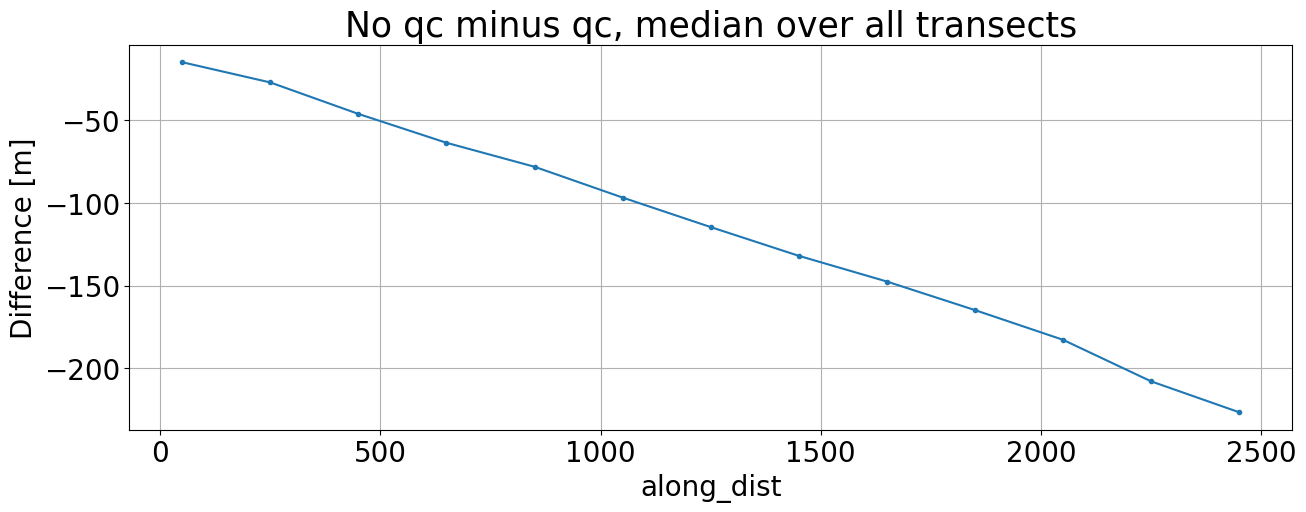

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(diff.index, solution_med, '.-')
ax.set_xlabel('along_dist')
ax.set_ylabel('Difference [m]')
ax.set_title("No qc minus qc, median over all transects")
ax.grid()

#### Std and trend per transect for along_dist = 1200m

In [20]:
# timeseries without quality control
if not os.path.isfile(main_datapath_output + 'cassie_sens_noqc.pkl'):
    settings_transects = {
        'along_dist': settings_ts['along_dist'],     # along-shore distance to use for computing the intersection
        'max_dist_origin': 10000,     # maximum distance to the origin of a transect in [m]
                     }
    cd_cassie_noqc = SDS_transects.compute_intersection(sl_cassie, transects, settings_transects)    
    pickle.dump(cd_cassie_noqc, open(main_datapath_output + 'cassie_sens_noqc.pkl', 'wb'))
else:
    cd_cassie_noqc = pickle.load(open(main_datapath_output + 'cassie_sens_noqc.pkl', 'rb'))

In [21]:
# timeseries with quality control
if not os.path.isfile(main_datapath_output + 'cassie_sens_qc.pkl'):
    settings_transects = { # parameters for computing intersections
                  'along_dist': settings_ts['along_dist'],    # along-shore distance to use for computing the intersection
                  'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                  'max_std':             15,        # max std for points around transect
                  'max_range':           30,        # max range for points around transect
                  'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                  'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                  'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                  'max_dist_origin':      10000,     # maximum distance to the origin of a transect in [m]
                }
    cd_cassie_qc = SDS_transects.compute_intersection_QC(sl_cassie, transects, settings_transects)
    pickle.dump(cd_cassie_qc, open(main_datapath_output + 'cassie_sens_qc.pkl', 'wb'))
else:
    cd_cassie_qc = pickle.load(open(main_datapath_output + 'cassie_sens_qc.pkl', 'rb'))

In [22]:
# standard deviation
std_noqc = []; std_qc = []
for transect in cd_cassie_noqc.keys():
    std_noqc.append(statistics.stdev(cd_cassie_noqc[transect][~np.isnan(cd_cassie_noqc[transect])]))
    std_qc.append(statistics.stdev(cd_cassie_qc[transect][~np.isnan(cd_cassie_qc[transect])]))
print('median std without quality control: ', np.nanmedian(std_noqc))
print('median std with quality control: ', np.nanmedian(std_qc))

median std without quality control:  111.0749617476627
median std with quality control:  168.79424348272374


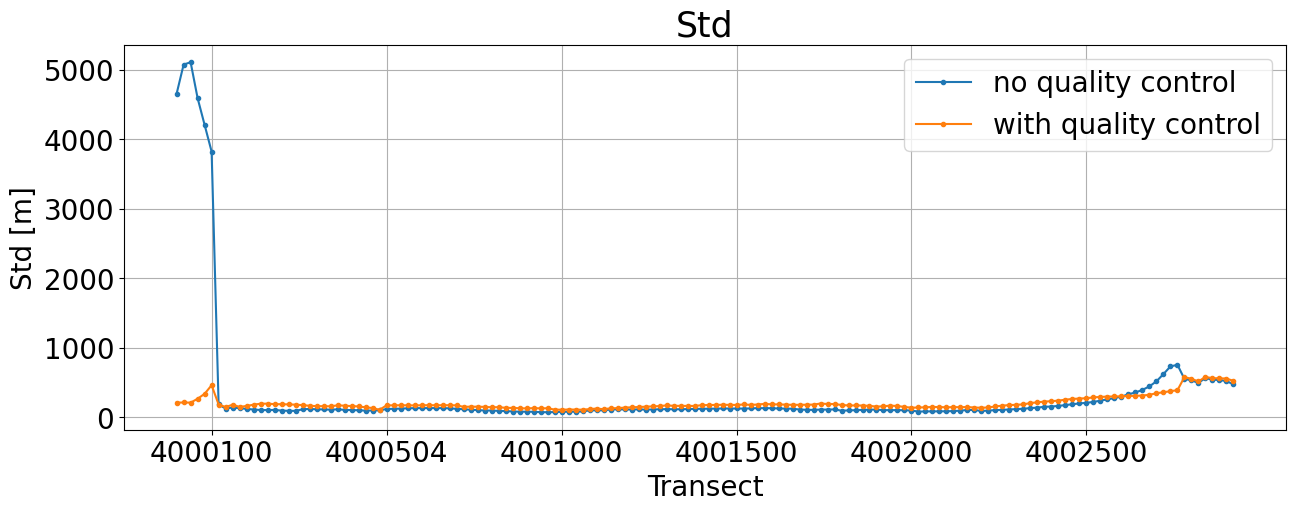

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(transects.keys(), std_noqc, '.-', label='no quality control')
ax.plot(transects.keys(), std_qc, '.-', label='with quality control')
ax.legend()
xticks = cd_along.columns[0::25]
ax.set_xticks(xticks)
ax.set_xlabel('Transect')
ax.set_ylabel('Std [m]')
ax.set_title('Std')
ax.grid()

In [24]:
# trend
trend_noqc = []; trend_qc = []
x = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie['dates']))
for transect in cd_cassie_noqc.keys():
    trend_noqc.append(CD_statistics.compute_trend(x, cd_cassie_noqc[transect]))
    trend_qc.append(CD_statistics.compute_trend(x, cd_cassie_qc[transect]))
print('median trend without quality control: ', np.nanmedian(trend_noqc))
print('median trend with quality control: ', np.nanmedian(trend_qc))

median trend without quality control:  -1.4835500000000001
median trend with quality control:  -1.5256500000000002


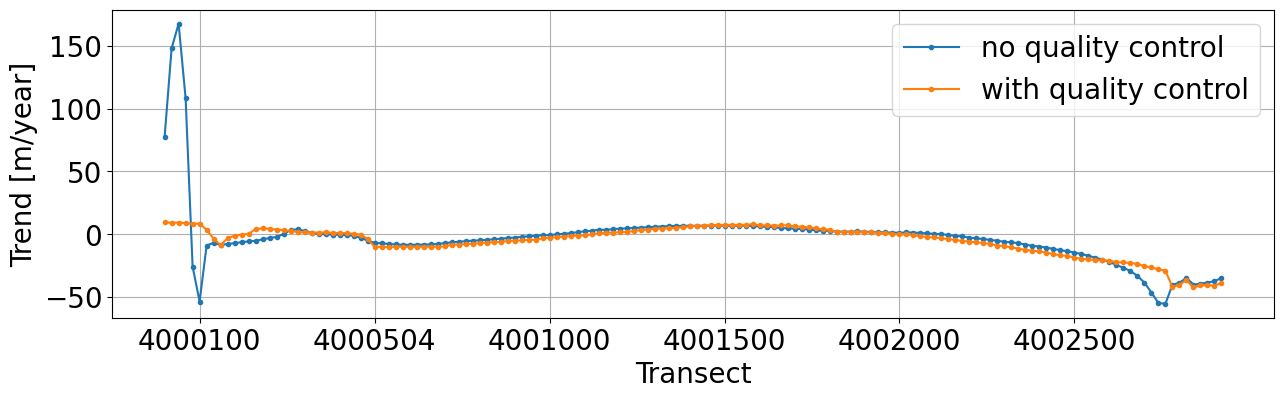

In [25]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(transects.keys(), trend_noqc, '.-', label='no quality control')
ax.plot(transects.keys(), trend_qc, '.-', label='with quality control')
ax.legend()
xticks = cd_along.columns[0::25]
ax.set_xticks(xticks)
ax.set_xlabel('Transect')
ax.set_ylabel('Trend [m/year]')
# ax.set_title('Trends')
ax.grid()
plt.savefig('../99_plot_dump/cassie_sens_trend_per_transect.pdf', bbox_inches='tight')

## Tidal correction

### Water levels

In [26]:
# get tide gauge data (North Sea)
tg_data = pd.read_csv(main_datapath_input + 'TG_rijkswaterstaat_1992_01_01-2021_12_31.csv', index_col='datetime[utc]', \
                  parse_dates=['datetime[utc]'])
tides_ts = np.array(tg_data['ssh[cm]']) / 100 # [m]

dates_ts = CD_helper_functions.datetime_to_decimal_numbers(tg_data.index)
dates_cassie = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie['dates']))
# reduce SDS-timeseries to the timespan where tide data is available
idx_tides_cassie = np.where((np.array(dates_cassie) < dates_ts[-1]) & (np.array(dates_cassie) > dates_ts[0]))[0]
dates_cassie = dates_cassie[idx_tides_cassie]

tides_cassie = np.interp(dates_cassie, dates_ts, tides_ts)

# reduce cross_distance and sl_dict to the timespan where water level data is available
cd_cassie_red = {}
for key in cd_cassie_qc.keys():
    cd_cassie_red[key] = cd_cassie_qc[key][idx_tides_cassie]

sl_cassie_red = {}
sl_cassie_red['dates'] = np.array(sl_cassie['dates'], dtype=object)[idx_tides_cassie]
sl_cassie_red['shorelines'] = np.array(sl_cassie['shorelines'], dtype=object)[idx_tides_cassie]

### Variable beach slope

In [27]:
def compute_variable_beach_slope(jarkus_data):
    # 1. For each sl_dict-date, find the corresponding time-index in jarkus
    sl_years = [_.year for _ in sl_cassie_red['dates']]
    jarkus_years = [pd.to_datetime(_.values).year for _ in jarkus_data.time]
    # idx: which jarkus-gradient belongs to which shoreline in sl_dict
    idx_time = [jarkus_years.index(_) for _ in sl_years]

    beach_slope = {}
    for transect in cd_cassie_red.keys():
        # 2. Relate cross_distance coordinate system to jarkus.cross_shore
        sl_cross = cd_cassie_red[transect] - 3000

        # 3. Buffer around the shoreline position for each point in time
        bnd_sea = sl_cross + settings_ts['grad_buffer']
        bnd_land = sl_cross - settings_ts['grad_buffer']
        # for each point in time, there is one cross-shore distance
        # bnd_sea/land define the maximum seaward/landward point along the profile to take into account for each point in time

        # 4. Get the gradients in the buffer zone
        # get the respective transect
        idx_along = np.where(jarkus_data.id == int(transect))[0][0]

        # filter the dataset for transect and time
        grad = jarkus_data.altitude_red_1st_derivative[idx_time, idx_along, :]
        if np.all(np.isnan(grad)):
            beach_slope[key] = np.nan
            continue

        # compute mean/median 
        if settings_ts['beach_slope'] == 'variable_mean':
            grad_mean = [] # mean gradient
            for t in range(0, len(grad.time)):
                idx_cross = np.where((grad.cross_shore <= bnd_sea[t]) & (grad.cross_shore >= bnd_land[t]))[0]
                grad_mean_temp = grad[t, idx_cross].mean().values
                grad_mean.append(round(float(grad_mean_temp), 3))
            # Interpolate over the nans
            grad_mean = np.array(pd.Series(grad_mean).interpolate())
            beach_slope[transect] = grad_mean
        elif settings_ts['beach_slope'] == 'variable_median':
            grad_median = [] # median gradient        
            for t in range(0, len(grad.time)):
                idx_cross = np.where((grad.cross_shore <= bnd_sea[t]) & (grad.cross_shore >= bnd_land[t]))[0]
                grad_median_temp = grad[t, idx_cross].median().values
                grad_median.append(round(float(grad_median_temp), 3))
            # Interpolate over the nans
            grad_median = np.array(pd.Series(grad_median).interpolate())
            beach_slope[transect] = grad_median
        elif settings_ts['beach_slope'] != str: # uniform beach slope
            beach_slope[transect] = settings_ts['beach_slope']
            
    return beach_slope    

In [28]:
# compute beach slope with *variable median* and different values for grad_buffer
if not os.path.isfile(main_datapath_output + 'cassie_sens_beach_slope_median_grad_buffer.pkl'):
    settings_ts['beach_slope'] = 'variable_median'
    grad_buffer_values = range(5,110,20)
    beach_slope_median = pd.DataFrame(columns=cd_cassie_red.keys(), index=grad_buffer_values)
    beach_slope_median.index.name = 'grad_buffer'

    jarkus_data = xr.open_dataset(main_datapath_output + 'transect_red_with_derivatives.nc', engine='netcdf4')

    for grad_buffer in grad_buffer_values:
        settings_ts['grad_buffer'] = grad_buffer
        beach_slope_median.loc[grad_buffer] = compute_variable_beach_slope(jarkus_data)
        
    beach_slope_median.to_pickle(main_datapath_output + 'cassie_sens_beach_slope_median_grad_buffer.pkl')
else:
    beach_slope_median = pd.read_pickle(main_datapath_output + 'cassie_sens_beach_slope_median_grad_buffer.pkl')

In [29]:
# compute beach slope with *variable mean* and different values for grad_buffer
if not os.path.isfile(main_datapath_output + 'cassie_sens_beach_slope_mean_grad_buffer.pkl'):
    settings_ts['beach_slope'] = 'variable_mean'
    transect_nr = list(transects.keys())
    grad_buffer_values = range(5,110,20)
    beach_slope_mean = pd.DataFrame(columns=cd_cassie_red.keys(), index=grad_buffer_values)
    beach_slope_mean.index.name = 'grad_buffer'
    
    jarkus_data = xr.open_dataset(main_datapath_output + 'transect_red_with_derivatives.nc', engine='netcdf4')

    for grad_buffer in grad_buffer_values:
        settings_ts['grad_buffer'] = grad_buffer
        beach_slope_mean.loc[grad_buffer] = compute_variable_beach_slope(jarkus_data)
        
    beach_slope_mean.to_pickle(main_datapath_output + 'cassie_sens_beach_slope_mean_grad_buffer.pkl')
else:
    beach_slope_mean = pd.read_pickle(main_datapath_output + 'cassie_sens_beach_slope_mean_grad_buffer.pkl')

### Correction

In [30]:
def tidal_correction(cd_dict, beach_slope, med_or_mean):
    '''
    compute and apply tidal correction to cd_dict
    '''
    cd_tidalcorr_df = pd.DataFrame(columns=beach_slope.columns, index=[med_or_mean + str(_) for _ in beach_slope.index])
    
    reference_elevation = 0
     # threshold the corrections to eliminate outliers
    thresh_pos = settings_ts['tide_corr_thresh']
    thresh_neg = -thresh_pos

    for grad_buffer in beach_slope.index:
        for transect in cd_dict.keys():
            corr = (tides_cassie - reference_elevation) / beach_slope.loc[grad_buffer, transect]
            corr[corr > thresh_pos] = thresh_pos
            corr[corr < thresh_neg] = thresh_neg
            cd_tidalcorr = cd_dict[transect] - corr
            cd_tidalcorr_sm = CD_statistics.moving_average(cd_tidalcorr, settings_ts['sm_window_size'])

            cd_tidalcorr_df.loc[med_or_mean+str(grad_buffer), transect] = cd_tidalcorr_sm
    return cd_tidalcorr_df

In [31]:
cd_tidalcorr_bsmedian = tidal_correction(cd_cassie_red, beach_slope_median, 'median')
cd_tidalcorr_bsmean = tidal_correction(cd_cassie_red, beach_slope_mean, 'mean')

/tmp/ipykernel_28215/498903977.py:14: RuntimeWarning: divide by zero encountered in divide
  corr = (tides_cassie - reference_elevation) / beach_slope.loc[grad_buffer, transect]
/tmp/ipykernel_28215/498903977.py:14: RuntimeWarning: invalid value encountered in divide
  corr = (tides_cassie - reference_elevation) / beach_slope.loc[grad_buffer, transect]
/tmp/ipykernel_28215/498903977.py:14: RuntimeWarning: divide by zero encountered in divide
  corr = (tides_cassie - reference_elevation) / beach_slope.loc[grad_buffer, transect]
/tmp/ipykernel_28215/498903977.py:14: RuntimeWarning: invalid value encountered in divide
  corr = (tides_cassie - reference_elevation) / beach_slope.loc[grad_buffer, transect]


In [32]:
# tidal correction with uniform beach slope
cd_tidalcorr_bs_uniform = pd.DataFrame(columns=beach_slope_mean.columns, index=['uniform'])
beach_slope_uniform = -0.01

reference_elevation = 0
thresh_pos = settings_ts['tide_corr_thresh']
thresh_neg = -thresh_pos

for transect in cd_cassie_red.keys():
    corr = (tides_cassie - reference_elevation) / beach_slope_uniform
    corr[corr > thresh_pos] = thresh_pos
    corr[corr < thresh_neg] = thresh_neg
    cd_tidalcorr = cd_cassie_red[transect] - corr
    cd_tidalcorr_sm = CD_statistics.moving_average(cd_tidalcorr, settings_ts['sm_window_size'])

    cd_tidalcorr_bs_uniform.loc['uniform', transect] = cd_tidalcorr_sm

### Compare uniform, mean and median for different buffer zone lengths

In [33]:
# move uncorrected shorelines from dict to dataframe
cd_cassie_red_df = pd.DataFrame(columns=beach_slope_mean.columns, index=['uncorrected'])
for transect in cd_cassie_red.keys():
    cd_cassie_red_df.loc['uncorrected', transect] = cd_cassie_red[transect]

# stack together corrected shorelines from mean, median and uniform beach slope, plus uncorrected shorelines
tidal_corr_stack = pd.concat([cd_tidalcorr_bsmedian, cd_tidalcorr_bsmean, cd_tidalcorr_bs_uniform, cd_cassie_red_df])

# compute statistics
tidal_corr_transect_medians = compute_transect_medians(tidal_corr_stack)
tcorr_std, tcorr_trend, tcorr_diff = compute_statistics(tidal_corr_stack, tidal_corr_transect_medians, sl_cassie_red)

std [m]


/tmp/ipykernel_28215/1561225331.py:25: RuntimeWarning: All-NaN slice encountered
  diff.append(np.nanmedian(transect_medians[transect] - ts))


,median,mean,min,max
median5,87.52,99.52,44.05,301.08
median25,88.15,101.64,37.01,302.87
median45,86.96,101.97,44.41,303.02
median65,87.67,102.37,45.18,303.47
median85,87.75,102.34,50.77,302.94
median105,88.09,102.39,47.43,303.74
mean5,87.52,99.52,44.05,301.08
mean25,87.67,101.22,42.67,303.04
mean45,87.75,101.61,45.39,303.83
mean65,87.26,101.99,46.1,303.84


trend [m/year]


,median,mean,min,max
median5,-0.38,-2.24,-46.06,13.99
median25,-1.15,-2.6,-46.22,15.73
median45,-0.81,-2.7,-46.17,15.02
median65,-1.2,-2.8,-46.25,15.22
median85,-1.22,-2.9,-46.4,15.04
median105,-1.12,-2.95,-46.57,15.15
mean5,-0.38,-2.24,-46.06,13.99
mean25,-0.89,-2.59,-46.22,14.35
mean45,-0.94,-2.71,-46.29,14.77
mean65,-1.09,-2.81,-46.3,15.42


Difference to median of all solutions [m]:


,median,mean,min,max
median5,-0.17,-0.82,-23.1,4.67
median25,-0.2,-0.57,-16.67,2.56
median45,-0.01,-0.16,-3.77,2.43
median65,0.02,0.13,-1.82,4.17
median85,0.12,0.19,-5.66,4.79
median105,0.13,0.19,-3.43,3.11
mean5,-0.17,-0.82,-23.1,4.67
mean25,-0.13,-0.57,-12.24,2.32
mean45,-0.12,-0.12,-3.71,2.63
mean65,-0.02,0.01,-2.01,2.87


In [34]:
# remove mean as results are almost the same as median
tcorr_std_ = tcorr_std['median'].drop(['mean5', 'mean25', 'mean45', 'mean65', 'mean85', 'mean105'])
tcorr_trend_ = tcorr_trend['median'].drop(['mean5', 'mean25', 'mean45', 'mean65', 'mean85', 'mean105'])
tcorr_diff_ = tcorr_diff['median'].drop(['mean5', 'mean25', 'mean45', 'mean65', 'mean85', 'mean105'])

In [35]:
bs_per_solution = pd.Series(index=tcorr_std_.index, dtype='float64')

for buffer in beach_slope_median.index:
    med_per_transect = []
    for transect in beach_slope_median.loc[buffer].index:
        med_per_transect.append(np.nanmedian(beach_slope_median.loc[buffer, transect]))
    bs_per_solution.loc['median'+str(buffer)] = np.nanmedian(med_per_transect)
bs_per_solution

/tmp/ipykernel_28215/3985296555.py:6: RuntimeWarning: All-NaN slice encountered
  med_per_transect.append(np.nanmedian(beach_slope_median.loc[buffer, transect]))


median5       -0.012167
median25      -0.012633
median45      -0.012750
median65      -0.012167
median85      -0.013000
median105     -0.013000
uniform             NaN
uncorrected         NaN
dtype: float64

In [36]:
bs_per_solution_plot = bs_per_solution.copy()
bs_per_solution_plot['uniform'] = 99
bs_per_solution_plot['uncorrected'] = 99

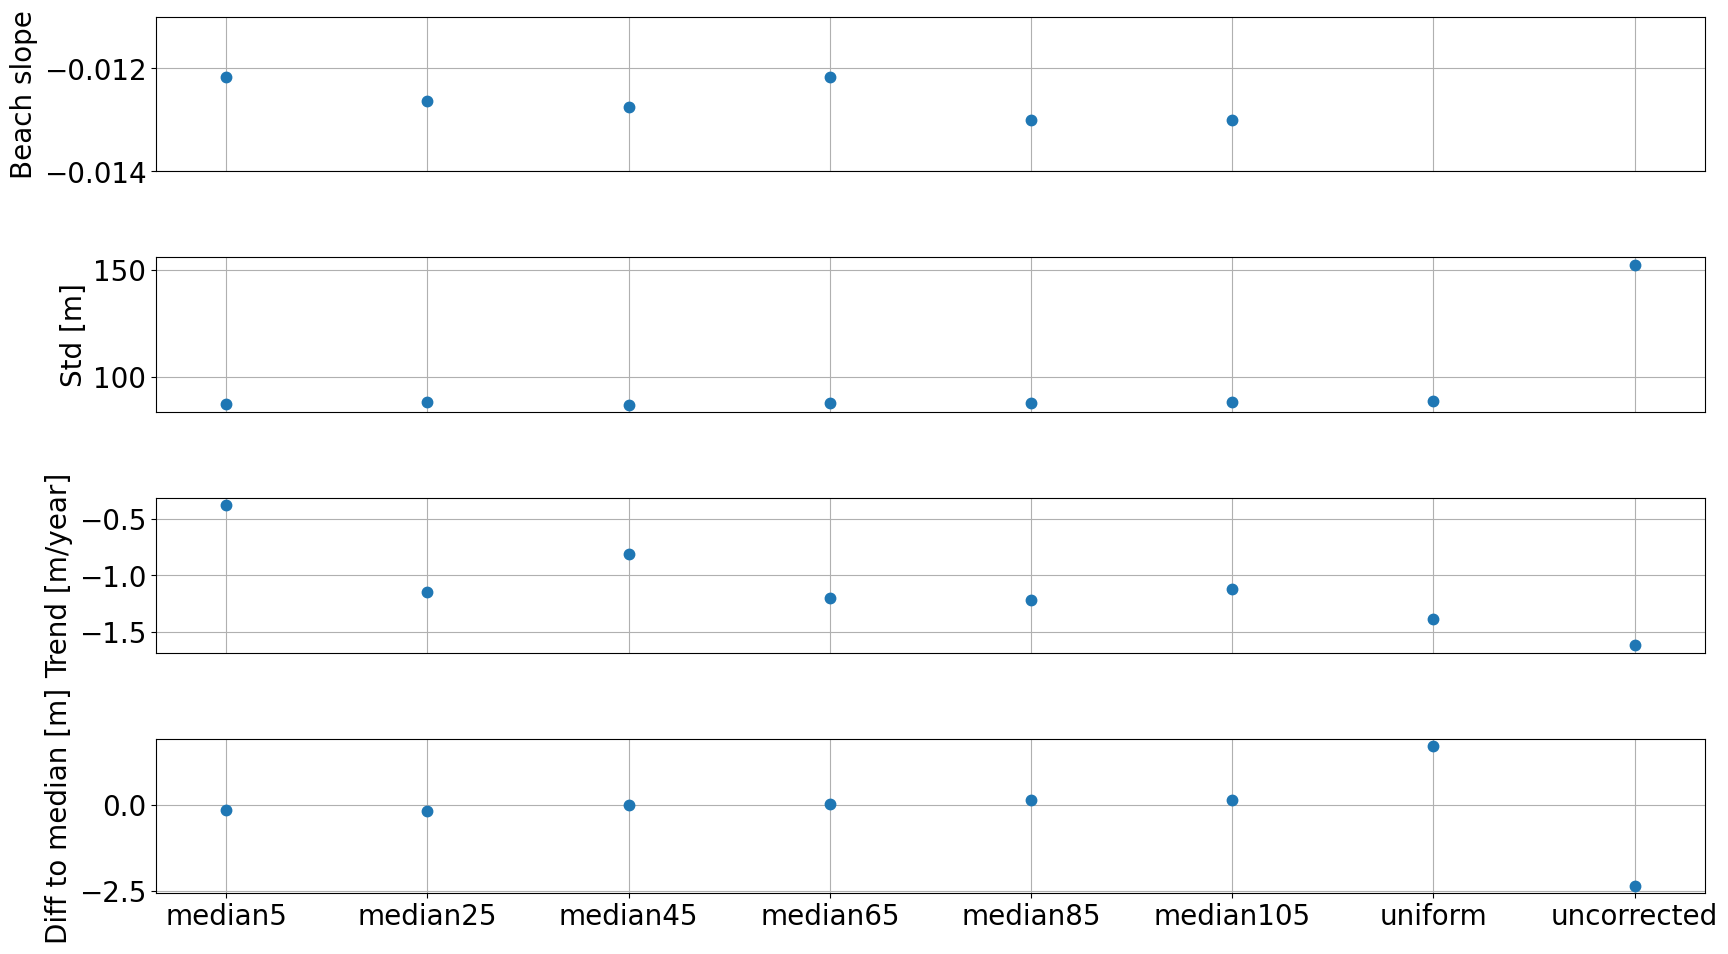

In [37]:
# Plots
fig, axs = plt.subplots(4,1,figsize=(17,10))
fig.tight_layout()

axs[0].plot(bs_per_solution, '.', markersize=15)
axs[0].plot(bs_per_solution_plot, '.', markersize=0)
axs[0].set_ylabel(r'Beach slope')
axs[0].set_ylim(-0.014, -0.011)
axs[0].grid()
axs[0].tick_params(axis='x', colors='white')

axs[1].plot(tcorr_std_, '.', markersize=15)
axs[1].set_ylabel('Std [m]')
axs[1].grid()
axs[1].tick_params(axis='x', colors='white')

axs[2].plot(tcorr_trend_, '.', markersize=15)
axs[2].set_ylabel('Trend [m/year]')
axs[2].grid()
axs[2].tick_params(axis='x', colors='white')

axs[3].plot(tcorr_diff_, '.', markersize=15)
axs[3].set_ylabel('Diff to median [m]')
axs[3].grid()

plt.savefig('../99_plot_dump/cassie_sens_tidal_corr_buffer.png', dpi=dpi, bbox_inches='tight')

### Compare TG vs EOT water levels
for median, 45 m buffer

In [38]:
 # get EOT20 data
data = pd.read_csv(main_datapath_output + 'tidal_correction_10minutes.csv', index_col='date',parse_dates=['date'])
tides_ts = np.array(data['corr_eot[cm]']) / 100 # [m]
    
dates_ts = CD_helper_functions.datetime_to_decimal_numbers(data.index)
dates_cassie = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie['dates']))
# reduce SDS-timeseries to the timespan where tide data is available
idx_tides_cassie = np.where((np.array(dates_cassie) < dates_ts[-1]) & (np.array(dates_cassie) > dates_ts[0]))[0]
dates_cassie = dates_cassie[idx_tides_cassie]

tides_cassie = np.interp(dates_cassie, dates_ts, tides_ts)

# reduce cross_distance and sl_dict to the timespan where water level data is available
cd_cassie_red_eot = {}
for key in cd_cassie_qc.keys():
    cd_cassie_red_eot[key] = cd_cassie_qc[key][idx_tides_cassie]

sl_cassie_red_eot = {}
sl_cassie_red_eot['dates'] = np.array(sl_cassie['dates'], dtype=object)[idx_tides_cassie]
sl_cassie_red_eot['shorelines'] = np.array(sl_cassie['shorelines'], dtype=object)[idx_tides_cassie]

# apply tidal correction
cd_tidalcorr_eot = tidal_correction(cd_cassie_red_eot, pd.DataFrame(beach_slope_median.loc[45]).transpose(), 'median')

/tmp/ipykernel_28215/498903977.py:14: RuntimeWarning: divide by zero encountered in divide
  corr = (tides_cassie - reference_elevation) / beach_slope.loc[grad_buffer, transect]


In [39]:
# difference TG-EOT
diff_tg_minus_eot = cd_tidalcorr_bsmedian.loc['median45'] - cd_tidalcorr_eot.loc['median45']

# median difference per transect
med_diff_tg_minus_eot = []
for transect in diff_tg_minus_eot.index:
    med_diff_tg_minus_eot.append(np.nanmedian(diff_tg_minus_eot[transect]))

/tmp/ipykernel_28215/107482808.py:7: RuntimeWarning: All-NaN slice encountered
  med_diff_tg_minus_eot.append(np.nanmedian(diff_tg_minus_eot[transect]))


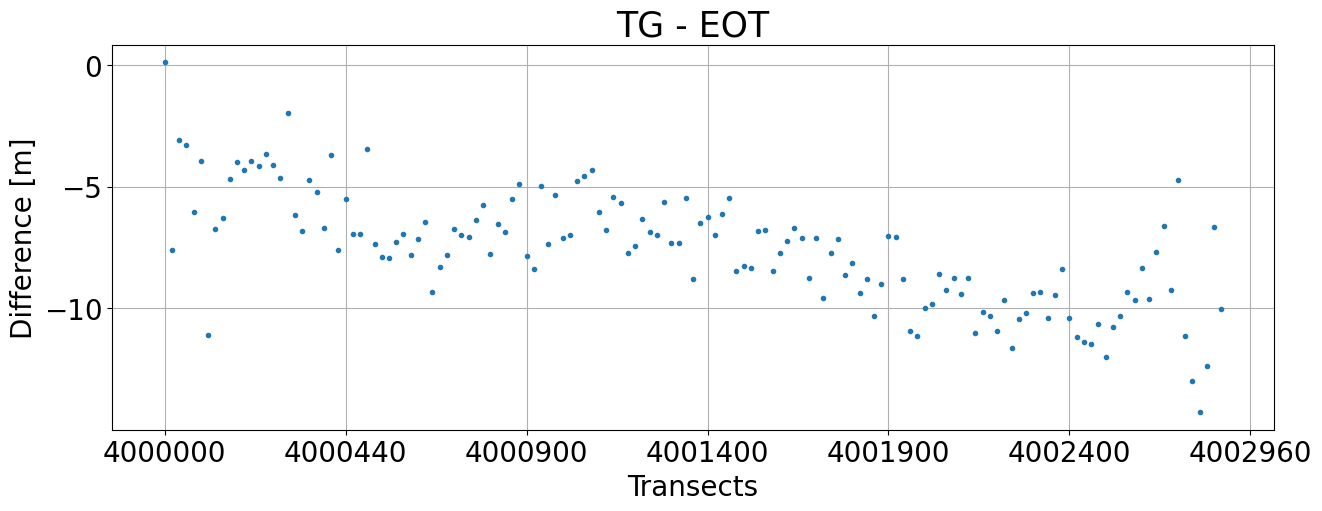

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_along_qc.columns, med_diff_tg_minus_eot, '.')
xticks = cd_along_qc.columns[0::25]
ax.set_xticks(xticks)
ax.set_xlabel('Transects')
ax.set_ylabel('Difference [m]')
ax.set_title("TG - EOT") # median beach slope 45 m buffer, median per transect
ax.grid()

In [41]:
trend_eot = []
x = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie_red['dates']))
for transect in cd_tidalcorr_eot.columns:
    ts = cd_tidalcorr_eot.loc['median45', transect]
    if np.all(np.isnan(ts)):
        trend_eot.append(np.nan)
        continue
    trend_eot.append(CD_statistics.compute_trend(x, ts))

In [42]:
trend_tg = []
for transect in cd_tidalcorr_bsmedian.loc['median45'].index:
    ts = cd_tidalcorr_bsmedian.loc['median45', transect]
    if np.all(np.isnan(ts)):
        trend_tg.append(np.nan)
        continue
    trend_tg.append(CD_statistics.compute_trend(x, ts))

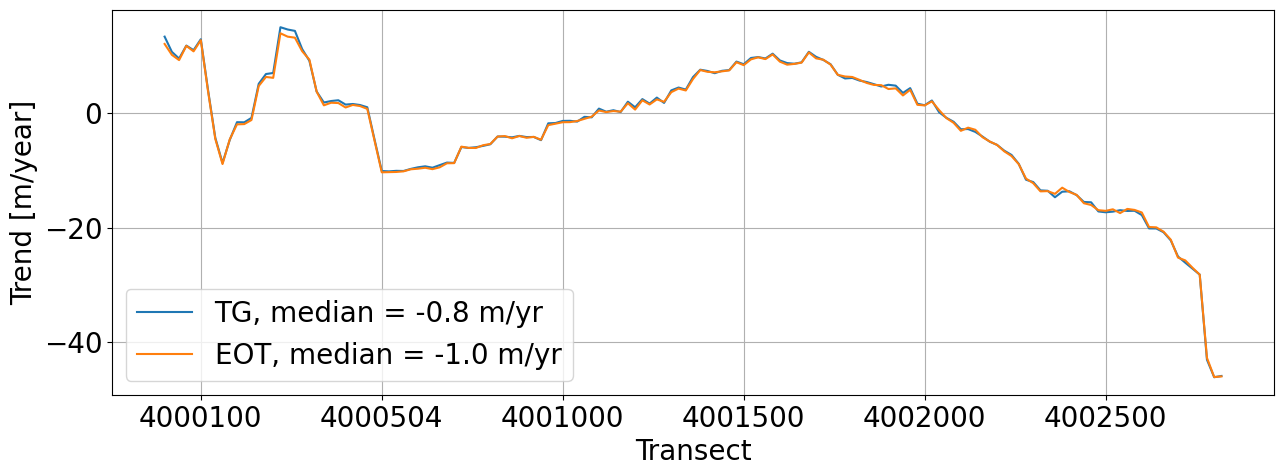

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(transects.keys(), trend_tg, label='TG, median = ' + str(round(np.nanmedian(trend_tg),1)) + ' m/yr')
ax.plot(transects.keys(), trend_eot, label='EOT, median = ' + str(round(np.nanmedian(trend_eot),1)) + ' m/yr')
ax.legend(loc='lower left')
xticks = cd_along.columns[0::25]
ax.set_xticks(xticks)
ax.set_xlabel('Transect')
ax.set_ylabel('Trend [m/year]')
ax.grid()

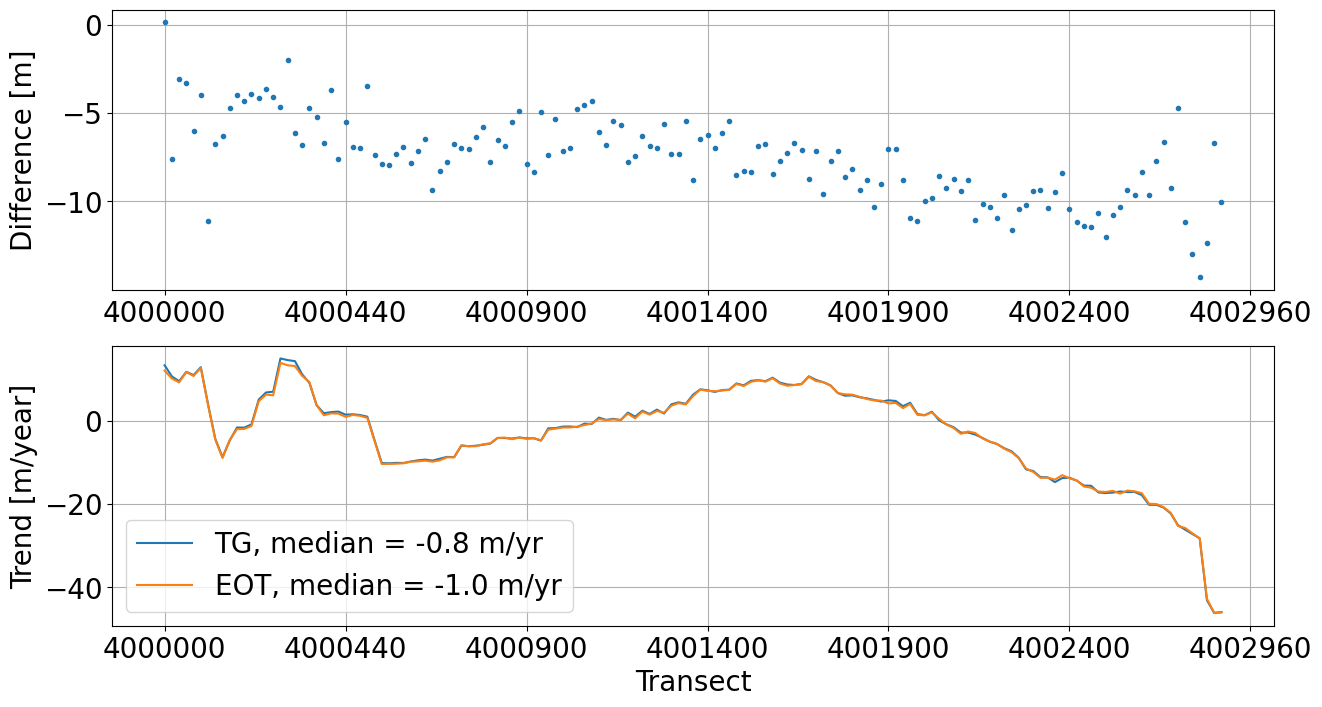

In [44]:
fig, axs = plt.subplots(2,1,figsize=(15,8))
axs[0].plot(cd_along_qc.columns, med_diff_tg_minus_eot, '.')
xticks = cd_along_qc.columns[0::25]
axs[0].set_xticks(xticks)
axs[0].set_ylabel('Difference [m]')
axs[0].grid()

axs[1].plot(transects.keys(), trend_tg, label='TG, median = ' + str(round(np.nanmedian(trend_tg),1)) + ' m/yr')
axs[1].plot(transects.keys(), trend_eot, label='EOT, median = ' + str(round(np.nanmedian(trend_eot),1)) + ' m/yr')
axs[1].legend(loc='lower left')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Transect')
axs[1].set_ylabel('Trend [m/year]')
axs[1].grid()
plt.savefig('../99_plot_dump/cassie_sens_eot_vs_tg.png', dpi=dpi, bbox_inches='tight')

### Plot to illustrate tidal correction
for one date (28.05.2020, water level = 0.67 o.NAP)

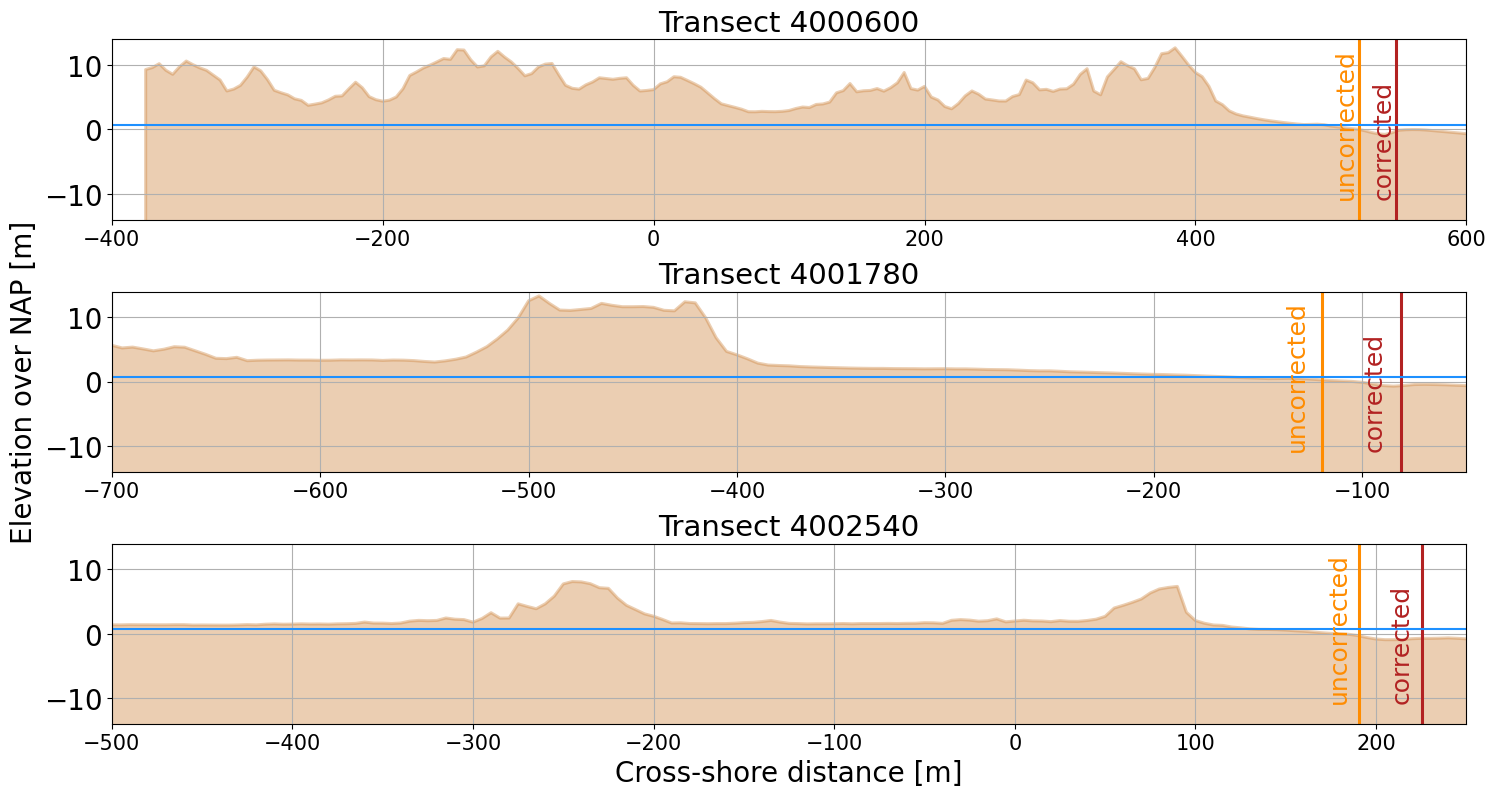

In [58]:
jarkus_data = xr.open_dataset(main_datapath_output + 'transect_red_with_derivatives.nc', engine='netcdf4')

fig, axs = plt.subplots(3,1,figsize=(15,8))
fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.rc('xtick', labelsize=15)   # fontsize of the tick labels

def plot_profile(transect_id, ax, xlim=None):
    time_idx = 128 # 28.05.2020
    lw = 2.2
    idx, = np.where(jarkus_data.id==transect_id)[0]
    profile = jarkus_data.altitude_red[28, idx, :]
    # ax.plot(jarkus_data.cross_shore, profile, c='peru', lw=lw)
    ax.fill_between(jarkus_data.cross_shore, profile, -20, color='peru', alpha=0.4, lw=lw)
    ax.set_xlim(xlim)
    ax.set_ylim([-14,14])
    
    # uncorrectd shoreline position
    sl_uncorr = cd_cassie_red[str(transect_id)][time_idx]-3000
    ax.axvline(sl_uncorr, c='darkorange', lw=lw)
    ax.text(sl_uncorr-18, -10, 'uncorrected', rotation='vertical', c='darkorange', fontsize=18)
    
    # corrected shoreline position
    sl_uncorr = cd_tidalcorr_bsmedian.loc['median45', str(transect_id)][time_idx]-3000
    ax.axvline(sl_uncorr, c='firebrick', lw=lw)
    ax.text(sl_uncorr-18, -10, 'corrected', rotation='vertical', c='firebrick', fontsize=18)
    
    ax.axhline(tides_cassie[128], c='dodgerblue')
    ax.set_title('Transect ' + str(transect_id), fontsize=21)
    ax.grid()
    
plot_profile(4000600, axs[0], [-400, 600])
plot_profile(4001780, axs[1], [-700, -50])
plot_profile(4002540, axs[2], [-500, 250])

axs[1].set_ylabel('Elevation over NAP [m]', fontsize=20)
axs[2].set_xlabel('Cross-shore distance [m]', fontsize=20);

plt.savefig('../99_plot_dump/profiles_tidal_correction.png', dpi=dpi, bbox_inches='tight')